# State space models

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy as sp

from statsmodels.regression.rolling import RollingOLS

In [13]:
import plotter.activate
from plotter import plot, plot_func

In [7]:
rng = np.random.default_rng()

## Kalman filter

We will use statsmodels for Kalman filtering. Here is a good description of the general model : https://www.statsmodels.org/0.8.0/statespace.html.
There some predefined models, but they are not very useful for my purposes. Best to always define a custom model by subclassing sm.tsa.statespace.MLEModel

### Local trend model

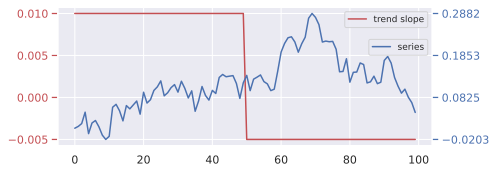

In [21]:
npts = 100
trend = 0.01*np.hstack([np.ones(npts//2), (-0.5)*np.ones(npts - npts//2)])
tser = (trend + rng.normal(scale=0.03, size=npts)).cumsum()

with plot(5, twin_ax=True) as p:
    p.ax().plot(trend, label='trend slope', c='r')
    p.ax(2).plot(tser, label='series')
    p.ax().legend()
    p.ax(2).legend(bbox_to_anchor=(1, 0.8))

Below the class for the local linear model. The model description can be found here https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_local_linear_trend.html.

Only hidden state can depend on the previous series values of itself, the observation can only depend on the hidden state. Thus to make unit root behaviour we need to go in 2 steps and augment the state dim. Thus in this case the dim of the state is two.

In [22]:
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [23]:
mod = LocalLinearTrend(tser)  

res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               LocalLinearTrend   Log Likelihood                 218.266
Date:                Tue, 27 Oct 2020   AIC                           -430.532
Time:                        16:49:32   BIC                           -422.777
Sample:                             0   HQIC                          -427.395
                                - 100                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement  6.309e-05    7.5e-05      0.841      0.400    -8.4e-05       0.000
sigma2.level           0.0005      0.000      3.394      0.001       0.000       0.001
sigma2.trend        

/home/vlad/miniconda3/envs/daily/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


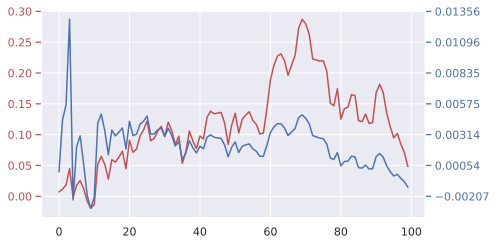

In [30]:
flt = mod.filter(params=res.params)  # filter with optimal params 
flt_ser = flt.filtered_state
with plot(twin_ax=True) as p:
    p.ax(1).plot(flt_ser.T[:, 0], c='r')
    p.ax(2).plot(flt_ser.T[:, 1])

Filtered series is obviously very close to the original one, since it only reflects the noise on the last technical step (not trend filtering). What's of interest is the filtered trend series itself, what kind of 1 or multistep predictions can it produce

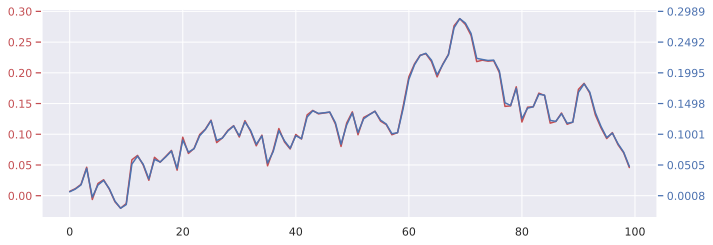

In [32]:
with plot(wide=True, twin_ax=True) as p:
    p.ax(1).plot(tser, c='r')
    p.ax(2).plot(flt_ser.T[:, 0])

In [33]:
# GO BACK TO THE MODEL ABOVE SINCE IT'S NOT WORKING VERY WELL

### Time-varying market beta

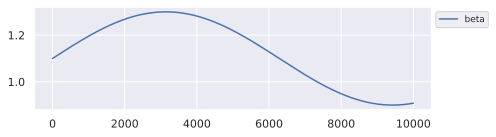

In [35]:
npts = 10000
beta = 1.1 + 0.2*np.sin(np.linspace(0, 5, npts))
with plot(4):
    plt.plot(beta, label='beta')

In [37]:
rets_mkt = rng.normal(scale=0.3/16, size=npts)
stock_idio_rets = rng.normal(scale=0.6/16, size=npts)
stock_rets = stock_idio_rets + beta*rets_mkt

print(np.corrcoef(rets_mkt, stock_rets))
sm.OLS(stock_rets, rets_mkt).fit().summary()

[[1.       0.491918]
 [0.491918 1.      ]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.242
Model:                            OLS   Adj. R-squared (uncentered):              0.242
Method:                 Least Squares   F-statistic:                              3194.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):                        0.00
Time:                        16:59:00   Log-Likelihood:                          18594.
No. Observations:               10000   AIC:                                 -3.719e+04
Df Residuals:                    9999   BIC:                                 -3.718e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1357      0.020     56.515      0.000       1.096       1.175
==============================================================================
Omnibus:                        1.097   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                1.128
Skew:                          -0.018   Prob(JB):                        0.569
Kurtosis:                       2.962   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Comments on free and specified model parameters:
* part of the params we specify directly, another part is free and optimized via MLE
* for local trend we left all 3 std coef to be optimized
* for time-varying beta we cannot do that : actully the ratio of two std coefs will play a role similar to estimation window if we do rolling OLS (there can be trends on larger scale and a lot of smaller trends in between - the model must know what to fit ; if left free the optimizer will produce the most granular model - vary volatily beta) -- can be base the estimation on the prediction instead????

In [49]:
class TimeVarBeta(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, std_ratio):
        # Model order
        k_states = k_posdef = 1

        # Initialize the statespace
        super(TimeVarBeta, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = rets_mkt.reshape((1, 1, len(rets_mkt)))
        self.ssm['transition'] = np.array([[1]])
        self.ssm['selection'] = np.array([[1]])
        self.ssm['state_cov'] = np.array([[std_ratio]])



    @property
    def start_params(self):
        return [1]*2


    def update(self, params, *args, **kwargs):
        params = super(TimeVarBeta, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]
        #self.ssm['state_cov',0,0] = params[1]

By balancing the std coef ratio we can produce a similar effect as changing rolling OLS window (so Kalman is not much better than rolling OLS in this case) --- find example where it is better; how is this related to Kalman equiv to EMA in certain problems??

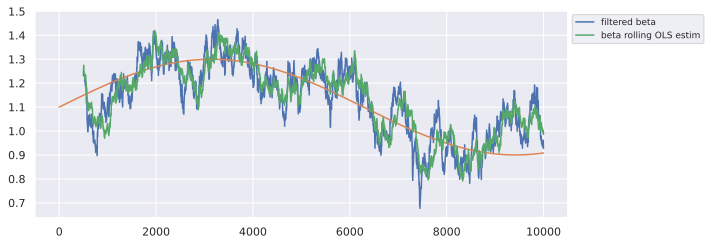

In [51]:
mod = TimeVarBeta(stock_rets, std_ratio=0.0001)
res = mod.fit()
flt = mod.filter(res.params)
beta_estim = RollingOLS(stock_rets, rets_mkt, window=500).fit(params_only=True)

with plot(wide=True) as p:
    fs = flt.filtered_state.flatten()
    fs[:500] = np.nan
    plt.plot(fs, label='filtered beta')
    plt.plot(beta)
    plt.plot(beta_estim.params.flatten(), label='beta rolling OLS estim')

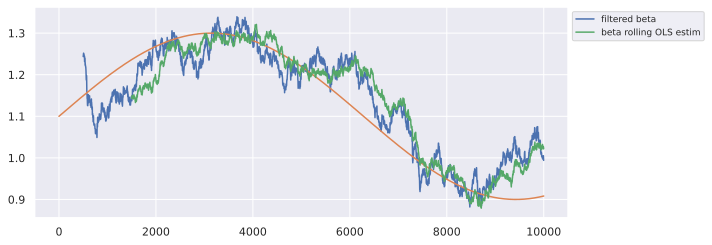

In [52]:
mod = TimeVarBeta(stock_rets, std_ratio=0.00001)
res = mod.fit()
flt = mod.filter(res.params)
beta_estim = RollingOLS(stock_rets, rets_mkt, window=1500).fit(params_only=True)

with plot(wide=True) as p:
    fs = flt.filtered_state.flatten()
    fs[:500] = np.nan
    plt.plot(fs, label='filtered beta')
    plt.plot(beta)
    plt.plot(beta_estim.params.flatten(), label='beta rolling OLS estim')

### Observation
interesting that we cannot achieve the 'smooth' beta estimation given the series noise, and that every new point brings new information;
if we increase the window -- the estimation is only more laggy, not smooth;

we can smooth the estimation ex post via smoothing, but any rolling smoothing (while having smooth shape in-sample) would produce a similar end-point pattern; 
we can only slightly smooth the noise by short window EMA

## Bayesian statistics using PyMC3

In [20]:
import pymc3
# it's quite slow, not sure if it can every be used in particle filtering for backtests :)

In [4]:
# Parameter values for prior and analytic posterior
n = 50
z = 10
alpha = 12
beta = 12
alpha_post = 22
beta_post = 52

# How many iterations of the Metropolis 
# algorithm to carry out for MCMC
iterations = 100000

In [5]:
basic_model = pymc3.Model()
with basic_model:
    # Define our prior belief about the fairness
    # of the coin using a Beta distribution
    theta = pymc3.Beta("theta", alpha=alpha, beta=beta)

    # Define the Bernoulli likelihood function
    y = pymc3.Binomial("y", n=n, p=theta, observed=z)

    # Carry out the MCMC analysis using the Metropolis algorithm
    # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
    start = pymc3.find_MAP() 

    # Use the Metropolis algorithm (as opposed to NUTS or HMC, etc.)
    step = pymc3.Metropolis()

    # Calculate the trace
    trace = pymc3.sample(iterations, step, start, random_seed=1, progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


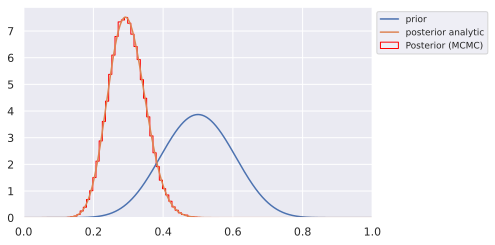

In [19]:
bins=50
with plot() as p:
    p.ax().hist(
        trace["theta"], bins, 
        histtype="step", density=True, 
        label="Posterior (MCMC)", color="red")
    p.ax().set_xlim((0,1))
    plot_func(lambda x: sp.stats.beta.pdf(x, alpha, beta), ax=p.ax(), label='prior')
    plot_func(lambda x: sp.stats.beta.pdf(x, alpha_post, beta_post), ax=p.ax(), label='posterior analytic')
